In [1]:
import numpy as np
import pandas as pd

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): apache-2.0
 97% 121M/124M [00:01<00:00, 97.7MB/s]
100% 124M/124M [00:01<00:00, 82.1MB/s]


In [4]:
!unzip oily-dry-and-normal-skin-types-dataset.zip

Archive:  oily-dry-and-normal-skin-types-dataset.zip
  inflating: Oily-Dry-Skin-Types/README.dataset.txt  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_10583924a54a7cbcf5d0_jpg.rf.7c4cb0ac9522f3a0faaf230527e1abe9.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_1d3b1b41c06745c89fb6_jpg.rf.9fe7b2181a36c2b6f67744be1af2fdd7.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_2e2591d4cf31b8e024a6_jpg.rf.e8a8db4db95cd0a0df0275d75fcd87a0.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_304ff9ea442145481f67_jpg.rf.26e1ca5ca2eb32f5c89509c670ca967a.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_33489ccedfbd77039b4d_jpg.rf.bff22d94ad08b5402f1feb8e304a7368.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_3cff4d4b05b7b88def12_jpg.rf.61f7ed0c6569bde348734178e19a55f7.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_4b06e68067862ee761ab_jpg.rf.52e7f8c3af0d6b1dd3e3f224b735fc18.jpg  
  inflating: Oily-Dry-Skin-Types/test/dry/dry_4e342ada282e73d14463_jpg.rf.3e22185034c87e49e38bf16b7c05

In [5]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [6]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [7]:
train_df = create_df("/content/Oily-Dry-Skin-Types/valid")
val_df = create_df("/content/Oily-Dry-Skin-Types/train")
test_df = create_df("/content/Oily-Dry-Skin-Types/test")

In [8]:
train_df = pd.concat([train_df, val_df, test_df])

In [9]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [10]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [11]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [12]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [13]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [14]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [15]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.9MB/s]


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [17]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [18]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04592353762827521 acc 0.45180483934946447 val loss 0.04102793648129418 acc 0.4666666666666667
Epochs 2 train loss 0.024172505125172883 acc 0.6731455771519238 val loss 0.02656783584564451 acc 0.6476190476190476
Epochs 3 train loss 0.016906487780967813 acc 0.7893692978976596 val loss 0.024167961355239628 acc 0.6952380952380952
Epochs 4 train loss 0.010459014858484552 acc 0.8790162633875446 val loss 0.02814454199775817 acc 0.653968253968254
Epochs 5 train loss 0.009110438060022829 acc 0.8936929789765966 val loss 0.027445196726965524 acc 0.6888888888888889
Epochs 6 train loss 0.005452302121621945 acc 0.9420864736215787 val loss 0.030753906946333627 acc 0.707936507936508
Epochs 7 train loss 0.004213862265181277 acc 0.9551765172550575 val loss 0.024118691588205003 acc 0.7523809523809524
Epochs 8 train loss 0.0028293217129293107 acc 0.9702499008330028 val loss 0.026252940344432044 acc 0.7396825396825397
Epochs 9 train loss 0.003144759746864645 acc 0.96390321301071 val lo

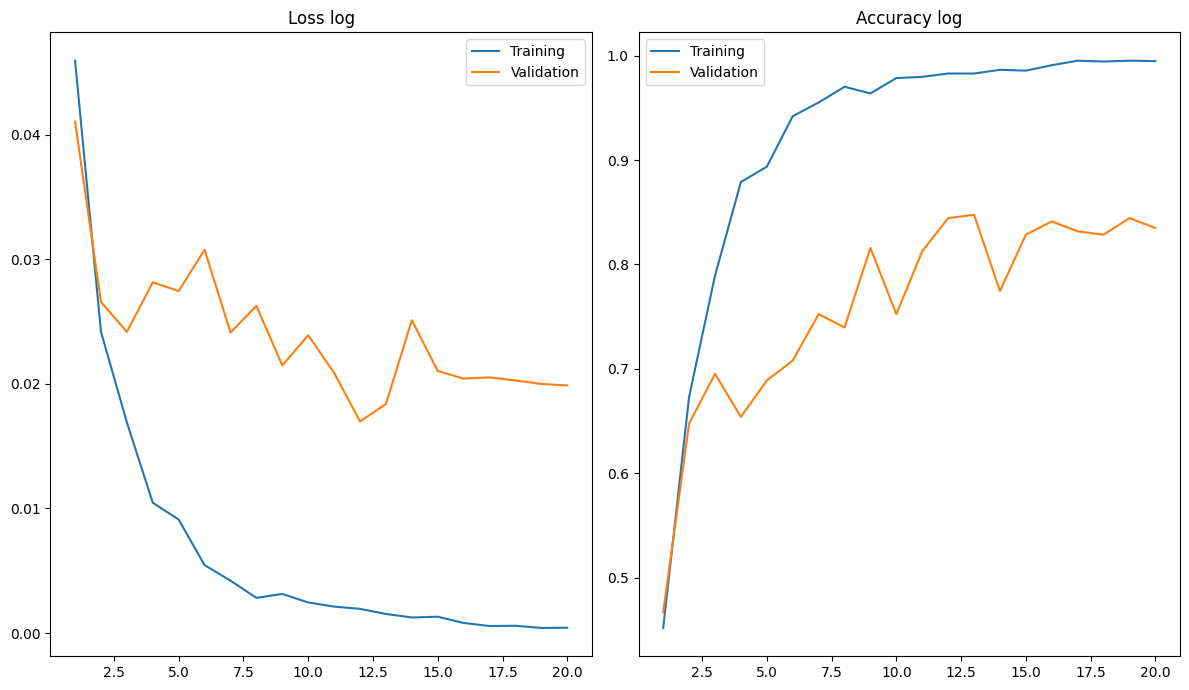

In [19]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [20]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [21]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

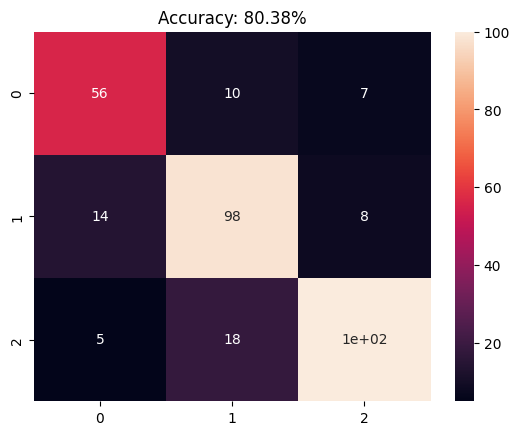

In [22]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [23]:
print(report)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        73
           1       0.78      0.82      0.80       120
           2       0.87      0.81      0.84       123

    accuracy                           0.80       316
   macro avg       0.80      0.80      0.80       316
weighted avg       0.81      0.80      0.80       316



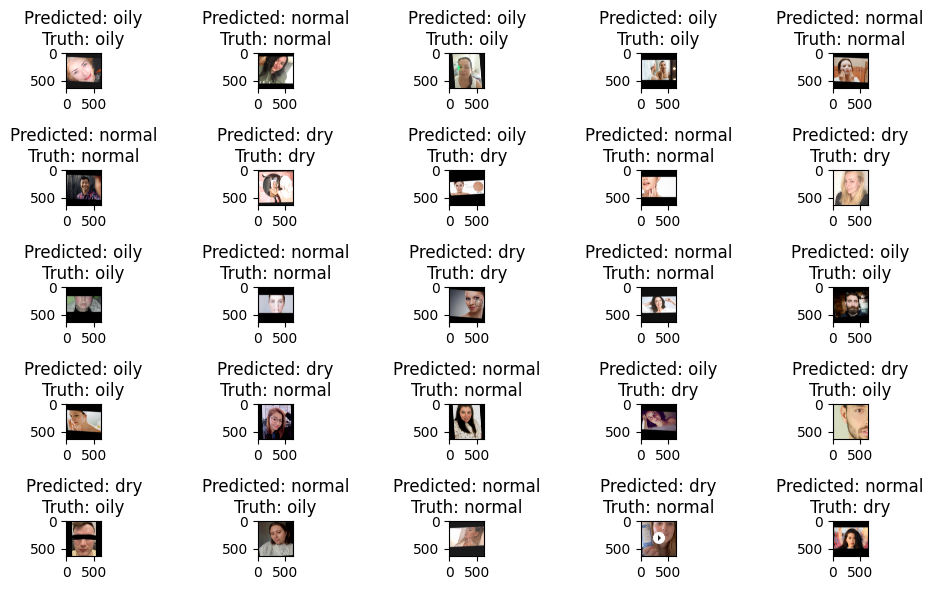

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

In [25]:
from keras.models import model_from_json

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: dry, normal, oily
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model architecture to JSON
model_json = model.to_json()
with open("skindetector.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("skindetector.weights.h5")  # Updated filename

print("Model saved successfully!")

Model saved successfully!


In [31]:
from keras.models import model_from_json

# Load the model architecture from JSON
with open("skindetector.json", "r") as json_file:
    model_json = json_file.read()
    model = model_from_json(model_json)

# Load the model weights
model.load_weights("skindetector.weights.h5")  # Updated filename

print("Model loaded successfully!")

Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
